# Loading DAVIS recordings with events and frames
Let's load a sample that contains a tuple of events, inertial measurement unit (IMU) recordings and images. 

In [8]:
import tonic

dataset = tonic.datasets.DAVISDATA(save_to='./data', recording='slider_depth')

data, targets = dataset[0]
events, imu, images = data

  0%|          | 0/18154269 [00:00<?, ?it/s]

The timestamps for events are from 0 to some 3.4 seconds. We also have timestamps for images, which are regularly sampled.

In [9]:
events["t"]

array([      0,       9,      25, ..., 3400249, 3400255, 3400269])

In [10]:
images["ts"]

array([      0,   38766,   77531,  116296,  155062,  193827,  232593,
        271358,  310123,  348889,  387654,  426419,  465185,  503950,
        542715,  581481,  620246,  659012,  697777,  736541,  775308,
        814073,  852838,  891604,  930369,  969135, 1007899, 1046665,
       1085431, 1124196, 1162961, 1201727, 1240492, 1279257, 1318023,
       1356788, 1395554, 1434319, 1473084, 1511850, 1550615, 1589380,
       1628146, 1666911, 1705676, 1744441, 1783207, 1821973, 1860738,
       1899502, 1938269, 1977034, 2015799, 2054565, 2093330, 2132096,
       2170861, 2209626, 2248392, 2287157, 2325922, 2364688, 2403453,
       2442218, 2480984, 2519749, 2558515, 2597280, 2636045, 2674811,
       2713576, 2752341, 2791107, 2829872, 2868637, 2907402, 2946168,
       2984934, 3023699, 3062463, 3101230, 3139995, 3178760, 3217526,
       3256291, 3295057, 3333822])

Let's bin our events into roughly the same time bins. The sampling frequency for images in microseconds can be calculated easily.

In [11]:
import numpy as np
mean_diff = np.diff(list(zip(images["ts"], images["ts"][1:]))).mean()
print(f"Average difference in image timestamps in microseconds: {mean_diff}")

Average difference in image timestamps in microseconds: 38765.37209302326


Say we wanted to apply the same transform to the event frames and grey-level images at the same time. Since the DAVIS dataset has a tuple of data, we have to make use of a helper function to apply our transforms specifically, as we can not apply any single transform to the data tuple at once.

In [12]:
import torch
import torchvision

sensor_size = tonic.datasets.DAVISDATA.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=mean_diff) 

image_center_crop = torchvision.transforms.Compose([torch.tensor, 
                                                    torchvision.transforms.CenterCrop((100,100))])

def data_transform(data):
    # first we have to unpack our data
    events, imu, images = data
    # we bin events to event frames
    frames = frame_transform(events)
    # then we can apply frame transforms to both event frames and images at the same time
    frames_cropped = image_center_crop(frames)
    images_cropped = image_center_crop(images["frames"])
    return frames_cropped, imu, images_cropped

Now we can load the same sample file again, this time with our custom transform function.

In [13]:
dataset = tonic.datasets.DAVISDATA(save_to='./data',
                                   recording='slider_depth',
                                   transform=data_transform)

data, targets = dataset[0]
frames_cropped, imu, images_cropped = data

All what's left is to plot binned event frame and image next to each other.

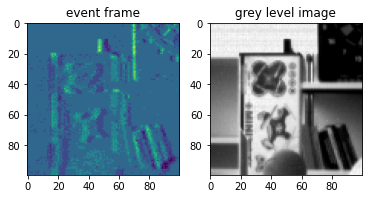

In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2)
event_frame = frames_cropped[10]
ax1.imshow(event_frame[0]-event_frame[1])
ax1.set_title("event frame")
ax2.imshow(images_cropped[10], cmap=mpl.cm.gray)
ax2.set_title("grey level image");